In [2]:
import os
import time
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = "Data"
TRAIN_PATH = os.path.join(DATA_DIR, "train-dset.parquet")
TEST_PATH = os.path.join(DATA_DIR, "test-dset-small.parquet")

# 1. Размеры

In [4]:
t0 = time.time()

train_lf = pl.scan_parquet(TRAIN_PATH)
test_lf = pl.scan_parquet(TEST_PATH)


train = train_lf.collect(streaming=True)
test = test_lf.collect(streaming=True)

print(f"[load] train: {train.shape}, test: {test.shape}, time: {time.time()-t0:.2f}s\n")

C:\Users\idine\AppData\Local\Temp\ipykernel_52048\19000350.py:7: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  train = train_lf.collect(streaming=True)
C:\Users\idine\AppData\Local\Temp\ipykernel_52048\19000350.py:8: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  test = test_lf.collect(streaming=True)


[load] train: (7781790, 14), test: (335348, 13), time: 4.27s



# 2. Cхема

In [5]:
print("[schema] dtypes (train):")
for k, v in train.schema.items():
    print(f"  {k}: {v}")
print()

[schema] dtypes (train):
  query_id: Int64
  item_id: Int64
  query_text: String
  item_title: String
  item_description: String
  query_cat: Float32
  query_mcat: Float64
  query_loc: Float32
  item_cat_id: Int32
  item_mcat_id: Int32
  item_loc: Int32
  price: Float32
  item_query_click_conv: Float32
  item_contact: Float32



In [7]:
train.head(5)

query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact
i64,i64,str,str,str,f32,f64,f32,i32,i32,i32,f32,f32,f32
4,7349717282,"""ботинки детские zara 21""","""Ботинки детские Zara""","""Новые полуботинки фирмы Zara. …",29.0,38.0,624480.0,29,2179540,638660,500.0,-1.0,0.0
4,7519735286,"""ботинки детские zara 21""","""Детские ботинки Zara унисекс""","""Крутые ботинки, в отличном сос…",29.0,38.0,624480.0,29,2179540,637640,250.0,-1.0,0.0
4,4384449104,"""ботинки детские zara 21""","""Ботинки детские zara""","""Челси димесезонные Zara В иде…",29.0,38.0,624480.0,29,2179540,623880,1500.0,-1.0,0.0
4,7283365509,"""ботинки детские zara 21""","""Детские ботиночки Zara 21 разм…","""АВИТО ДОСТАВКА .21 РАЗМЕР.""",29.0,38.0,624480.0,29,2179540,628530,220.0,-1.0,0.0
4,4452768560,"""ботинки детские zara 21""","""Детские ботиночки zara размер …","""Детские ботинки Zara Размер 2…",29.0,38.0,624480.0,29,2179540,637640,1648.0,-1.0,1.0


# 3. Пропуски

In [8]:
missing = (
    train
    .select([pl.col(c).is_null().sum().alias(c) for c in train.columns])
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
    .with_columns([
        (pl.col("nulls") / train.height).alias("null_frac")
    ])
    .sort("nulls", descending=True)
)
print("[missing] Количество и доля пропусков по колонкам:")
missing


[missing] Количество и доля пропусков по колонкам:


column,nulls,null_frac
str,u32,f64
"""query_mcat""",1761233,0.226327
"""item_title""",107,0.000014
"""item_description""",107,0.000014
"""query_id""",0,0.0
"""item_id""",0,0.0
…,…,…
"""item_mcat_id""",0,0.0
"""item_loc""",0,0.0
"""price""",0,0.0


In [9]:
print(missing)

shape: (14, 3)
┌───────────────────────┬─────────┬───────────┐
│ column                ┆ nulls   ┆ null_frac │
│ ---                   ┆ ---     ┆ ---       │
│ str                   ┆ u32     ┆ f64       │
╞═══════════════════════╪═════════╪═══════════╡
│ query_mcat            ┆ 1761233 ┆ 0.226327  │
│ item_title            ┆ 107     ┆ 0.000014  │
│ item_description      ┆ 107     ┆ 0.000014  │
│ query_id              ┆ 0       ┆ 0.0       │
│ item_id               ┆ 0       ┆ 0.0       │
│ …                     ┆ …       ┆ …         │
│ item_mcat_id          ┆ 0       ┆ 0.0       │
│ item_loc              ┆ 0       ┆ 0.0       │
│ price                 ┆ 0       ┆ 0.0       │
│ item_query_click_conv ┆ 0       ┆ 0.0       │
│ item_contact          ┆ 0       ┆ 0.0       │
└───────────────────────┴─────────┴───────────┘


# 4. Уникальные значения

In [10]:
def nunique(df: pl.DataFrame, col: str) -> int:
    return df.select(pl.col(col).n_unique()).item()

print("[unique] уникальных query_id (train/test):", nunique(train, "query_id"), nunique(test, "query_id"))
print("[unique] уникальных item_id   (train/test):", nunique(train, "item_id"), nunique(test, "item_id"))
print()

[unique] уникальных query_id (train/test): 678190 12505
[unique] уникальных item_id   (train/test): 5773058 321625



# Числовые данные

In [20]:
num_cols = [c for c, t in train.schema.items() if t in pl.NUMERIC_DTYPES]
if num_cols:
    # Для компактности считаем набор статистик по каждой числовой колонке
    stats_rows = []
    for c in num_cols:
        s = (
            train
            .select(
                pl.col(c).cast(pl.Float64),
                pl.len().alias("__n")
            )
            .select([
                pl.lit(c).alias("column"),
                pl.col(c).mean().alias("mean"),
                pl.col(c).std().alias("std"),
                pl.col(c).min().alias("min"),
                pl.col(c).quantile(0.25).alias("p25"),
                pl.col(c).median().alias("p50"),
                pl.col(c).quantile(0.75).alias("p75"),
                pl.col(c).quantile(0.95).alias("p95"),
                pl.col(c).quantile(0.99).alias("p99"),
                pl.col(c).max().alias("max"),
            ])
        )
        stats_rows.append(s)
    num_stats = pl.concat(stats_rows)
    print("[numeric] базовые статистики:")
    res = num_stats.sort("column")

C:\Users\idine\AppData\Local\Temp\ipykernel_52048\1822074572.py:1: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  num_cols = [c for c, t in train.schema.items() if t in pl.NUMERIC_DTYPES]


[numeric] базовые статистики:


In [21]:
res

column,mean,std,min,p25,p50,p75,p95,p99,max
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""item_cat_id""",58.124696,42.391457,0.0,24.0,31.0,111.0,114.0,114.0,426.0
"""item_contact""",0.044057,0.205223,0.0,0.0,0.0,0.0,0.0,1.0,1.0
"""item_id""",5.9148e9,2.0082e9,112067.0,4.2131e9,7.3524e9,7.5281e9,7.5834e9,7.6078e9,7.6620e9
"""item_loc""",644144.202853,20381.792652,621551.0,637640.0,639740.0,653240.0,661010.0,662810.0,905811.0
"""item_mcat_id""",1.0722e6,1.0320e6,0.0,3726.0,1.175242e6,2.275142e6,2.30187e6,2.302905e6,2.303084e6
…,…,…,…,…,…,…,…,…,…
"""price""",1.5637e6,9.4102e8,0.0,600.0,2600.0,13100.0,310000.0,4.6e6,1.0000e12
"""query_cat""",44.657394,48.492066,0.0,5.0,27.0,106.0,114.0,114.0,442.0
"""query_id""",412381.94137,238226.163007,0.0,206089.0,412365.0,618746.0,783362.0,816492.0,824764.0


In [31]:
print(res)

shape: (11, 10)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column    ┆ mean      ┆ std       ┆ min      ┆ … ┆ p75       ┆ p95       ┆ p99       ┆ max       │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ f64       ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ item_cat_ ┆ 58.124696 ┆ 42.391457 ┆ 0.0      ┆ … ┆ 111.0     ┆ 114.0     ┆ 114.0     ┆ 426.0     │
│ id        ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ item_cont ┆ 0.044057  ┆ 0.205223  ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 1.0       │
│ act       ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ item_id   ┆ 5.9148e9  ┆ 2.0082e9  ┆ 112067.0 ┆ … ┆ 7.5281e9  ┆ 7.5834e9  

# Таргет: баланс классов

In [23]:
if "item_contact" in train.columns:
    tgt = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("item_contact")
        .agg(pl.len().alias("cnt"))
        .with_columns((pl.col("cnt") / pl.col("cnt").sum()).alias("frac"))
        .sort("item_contact")
    )
    print("[target] распределение item_contact:")
    print(f"[target] положительная доля: {train.select(pl.col('item_contact').cast(pl.Float64).mean()).item():.4f}\n")

[target] распределение item_contact:
[target] положительная доля: 0.0441



In [24]:
tgt

item_contact,cnt,frac
i32,u32,f64
0,7438944,0.955943
1,342846,0.044057


In [30]:
print(tgt)

shape: (2, 3)
┌──────────────┬─────────┬──────────┐
│ item_contact ┆ cnt     ┆ frac     │
│ ---          ┆ ---     ┆ ---      │
│ i32          ┆ u32     ┆ f64      │
╞══════════════╪═════════╪══════════╡
│ 0            ┆ 7438944 ┆ 0.955943 │
│ 1            ┆ 342846  ┆ 0.044057 │
└──────────────┴─────────┴──────────┘


# Группы по запросам: размер пула, доля позитивов, цена внутри запроса

In [25]:
if "item_contact" in train.columns and "price" in train.columns:
    per_query = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("query_id")
        .agg([
            pl.len().alias("n_items"),
            pl.col("item_contact").sum().alias("n_pos"),
            pl.col("item_contact").mean().alias("pos_rate"),
            pl.col("price").mean().alias("price_mean"),
            pl.col("price").median().alias("price_median")
        ])
        .sort("n_items", descending=True)
    )
    print("[group] примеры агрегатов по query_id:")
    print(per_query.head(10))
    print()

    # Распределение размера пулов и доли позитивов (в числах)
    print("[group] размер пула кандидатов (квантили):")
    print(per_query.select([
        pl.col("n_items").min().alias("min"),
        pl.col("n_items").quantile(0.5).alias("p50"),
        pl.col("n_items").quantile(0.9).alias("p90"),
        pl.col("n_items").quantile(0.99).alias("p99"),
        pl.col("n_items").max().alias("max"),
    ]))
    print()

[group] примеры агрегатов по query_id:
shape: (10, 6)
┌──────────┬─────────┬───────┬──────────┬───────────────┬──────────────┐
│ query_id ┆ n_items ┆ n_pos ┆ pos_rate ┆ price_mean    ┆ price_median │
│ ---      ┆ ---     ┆ ---   ┆ ---      ┆ ---           ┆ ---          │
│ i64      ┆ u32     ┆ i32   ┆ f64      ┆ f32           ┆ f32          │
╞══════════╪═════════╪═══════╪══════════╪═══════════════╪══════════════╡
│ 757116   ┆ 500     ┆ 6     ┆ 0.012    ┆ 20046.0       ┆ 0.0          │
│ 636573   ┆ 480     ┆ 0     ┆ 0.0      ┆ 31602.707031  ┆ 10000.0      │
│ 762063   ┆ 478     ┆ 0     ┆ 0.0      ┆ 20771.828125  ┆ 0.0          │
│ 573576   ┆ 467     ┆ 0     ┆ 0.0      ┆ 18884.4375    ┆ 0.0          │
│ 240076   ┆ 464     ┆ 1     ┆ 0.002155 ┆ 30740.908203  ┆ 0.0          │
│ 115042   ┆ 460     ┆ 0     ┆ 0.0      ┆ 31189.222656  ┆ 0.0          │
│ 29012    ┆ 414     ┆ 0     ┆ 0.0      ┆ 37068.839844  ┆ 0.0          │
│ 532666   ┆ 387     ┆ 0     ┆ 0.0      ┆ 25767.701172  ┆ 0.0         

 # Категории и локации

In [26]:
for a, b, name in [
    ("query_cat", "item_cat_id", "cat_match"),
    ("query_mcat", "item_mcat_id", "mcat_match"),
    ("query_loc", "item_loc", "loc_match"),
]:
    if a in train.columns and b in train.columns:
        rate = (
            train
            .with_columns((pl.col(a) == pl.col(b)).alias(name))
            .select(pl.col(name).cast(pl.Int32).mean())
            .item()
        )
        print(f"[match] доля совпадений {a} == {b}: {rate:.4f}")
print()

[match] доля совпадений query_cat == item_cat_id: 0.6985
[match] доля совпадений query_mcat == item_mcat_id: 0.3921
[match] доля совпадений query_loc == item_loc: 0.4853



In [27]:
def topk(df: pl.DataFrame, col: str, k: int = 10) -> pl.DataFrame:
    return df.group_by(col).agg(pl.len().alias("cnt")).sort("cnt", descending=True).head(k)

for col in ["query_cat", "query_mcat", "query_loc", "item_cat_id", "item_mcat_id", "item_loc"]:
    if col in train.columns:
        print(f"[top] {col}:")
        print(topk(train, col, 10))
        print()

[top] query_cat:
shape: (10, 2)
┌───────────┬─────────┐
│ query_cat ┆ cnt     │
│ ---       ┆ ---     │
│ f32       ┆ u32     │
╞═══════════╪═════════╡
│ 0.0       ┆ 1747975 │
│ 114.0     ┆ 693215  │
│ 27.0      ┆ 679839  │
│ 112.0     ┆ 652631  │
│ 10.0      ┆ 546969  │
│ 111.0     ┆ 458653  │
│ 29.0      ┆ 283786  │
│ 9.0       ┆ 242959  │
│ 5.0       ┆ 219190  │
│ 24.0      ┆ 188211  │
└───────────┴─────────┘

[top] query_mcat:
shape: (10, 2)
┌────────────┬─────────┐
│ query_mcat ┆ cnt     │
│ ---        ┆ ---     │
│ f64        ┆ u32     │
╞════════════╪═════════╡
│ null       ┆ 1761233 │
│ 62.0       ┆ 652631  │
│ 61.0       ┆ 456171  │
│ 17.0       ┆ 291755  │
│ 14.0       ┆ 229536  │
│ 6.0        ┆ 218375  │
│ 63.0       ┆ 210003  │
│ 37.0       ┆ 198222  │
│ 3838.0     ┆ 123882  │
│ 38.0       ┆ 121708  │
└────────────┴─────────┘

[top] query_loc:
shape: (10, 2)
┌───────────┬─────────┐
│ query_loc ┆ cnt     │
│ ---       ┆ ---     │
│ f32       ┆ u32     │
╞═══════════╪════════

# Тексты

In [29]:
text_cols = [c for c, t in train.schema.items() if t == pl.Utf8]
has_text = all(x in train.columns for x in ["query_text", "item_title", "item_description"])

if has_text:
    # Предобработка: нижний регистр, очистка, токенизация по пробелам
    # Регулярка удаляет все не-буквенно-цифровые символы, сводит последовательности к одному пробелу.
    def tokenize(col: str) -> pl.Expr:
        return (
            pl.col(col)
            .cast(pl.Utf8)
            .fill_null("")
            .str.to_lowercase()
            .str.replace_all(r"[^0-9\p{L}]+", " ")
            .str.strip_chars()  # <--- замена .strip()
            .str.split(" ")
            .list.eval(pl.element().filter(pl.element() != ""))  # убираем пустые
        )


    train = train.with_columns([
        tokenize("query_text").alias("query_tokens"),
        tokenize("item_title").alias("title_tokens"),
        tokenize("item_description").alias("desc_tokens"),
    ])

    # Длины в словах
    train = train.with_columns([
        pl.col("query_tokens").list.len().alias("query_len"),
        pl.col("title_tokens").list.len().alias("title_len"),
        pl.col("desc_tokens").list.len().alias("desc_len"),
    ])

    print("[text] квантили длин (слов):")
    print(
        train.select([
            pl.col("query_len").quantile(0.5).alias("query_p50"),
            pl.col("query_len").quantile(0.95).alias("query_p95"),
            pl.col("title_len").quantile(0.5).alias("title_p50"),
            pl.col("title_len").quantile(0.95).alias("title_p95"),
            pl.col("desc_len").quantile(0.5).alias("desc_p50"),
            pl.col("desc_len").quantile(0.95).alias("desc_p95"),
        ])
    )
    print()

    # Пересечение токенов между запросом и заголовком/описанием
    # Используем set_intersection для уникальных токенов
    train = train.with_columns([
        pl.col("query_tokens").list.set_intersection(pl.col("title_tokens")).list.len().alias("overlap_q_title"),
        pl.col("query_tokens").list.set_intersection(pl.col("desc_tokens")).list.len().alias("overlap_q_desc"),
    ])

    print("[text] среднее пересечение токенов:")
    print(
        train.select([
            pl.col("overlap_q_title").mean().alias("mean_overlap_q_title"),
            pl.col("overlap_q_desc").mean().alias("mean_overlap_q_desc"),
        ])
    )
    print()


[text] квантили длин (слов):
shape: (1, 6)
┌───────────┬───────────┬───────────┬───────────┬──────────┬──────────┐
│ query_p50 ┆ query_p95 ┆ title_p50 ┆ title_p95 ┆ desc_p50 ┆ desc_p95 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---      ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64      ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╡
│ 2.0       ┆ 5.0       ┆ 5.0       ┆ 9.0       ┆ 49.0     ┆ 146.0    │
└───────────┴───────────┴───────────┴───────────┴──────────┴──────────┘

[text] среднее пересечение токенов:
shape: (1, 2)
┌──────────────────────┬─────────────────────┐
│ mean_overlap_q_title ┆ mean_overlap_q_desc │
│ ---                  ┆ ---                 │
│ f64                  ┆ f64                 │
╞══════════════════════╪═════════════════════╡
│ 1.363154             ┆ 1.283809            │
└──────────────────────┴─────────────────────┘



# Поведенческий сигнал vs таргет

In [32]:
if "item_query_click_conv" in train.columns and "item_contact" in train.columns:
    # Корреляция Пирсона (item_contact приводим к float)
    corr = train.select(pl.corr(pl.col("item_query_click_conv"), pl.col("item_contact").cast(pl.Float64))).item()
    print(f"[corr] corr(item_query_click_conv, item_contact): {corr:.4f}")

    # Средние значения для 0/1
    by_target = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("item_contact")
        .agg(pl.col("item_query_click_conv").mean().alias("conv_mean"))
        .sort("item_contact")
    )
    print("[conv] среднее conv по классам item_contact:")
    print(by_target)
    print()


[corr] corr(item_query_click_conv, item_contact): 0.0190
[conv] среднее conv по классам item_contact:
shape: (2, 2)
┌──────────────┬───────────┐
│ item_contact ┆ conv_mean │
│ ---          ┆ ---       │
│ i32          ┆ f32       │
╞══════════════╪═══════════╡
│ 0            ┆ -0.839106 │
│ 1            ┆ -0.803783 │
└──────────────┴───────────┘



In [33]:
def sample_for_plots(df: pl.DataFrame, n: int = 200_000, seed: int = 42) -> pl.DataFrame:
    if df.height <= n:
        return df
    return df.sample(n=n, shuffle=True, seed=seed)

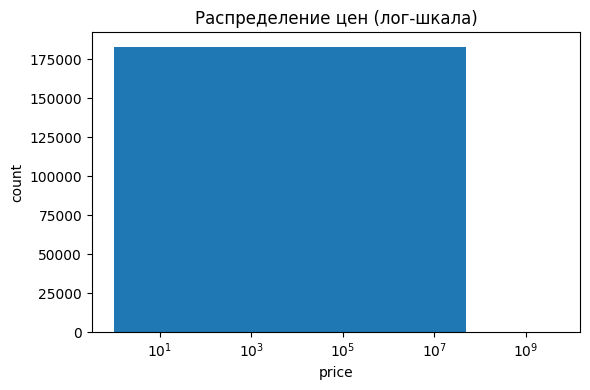

In [35]:
plot_df = sample_for_plots(train)

# Гистограмма цен (лог-шкала)
if "price" in plot_df.columns:
    price_vals = plot_df.select(pl.col("price").cast(pl.Float64)).to_series().to_numpy()
    price_vals = price_vals[np.isfinite(price_vals) & (price_vals > 0)]
    if len(price_vals) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(price_vals, bins=100)
        plt.xscale("log")
        plt.title("Распределение цен (лог-шкала)")
        plt.xlabel("price")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

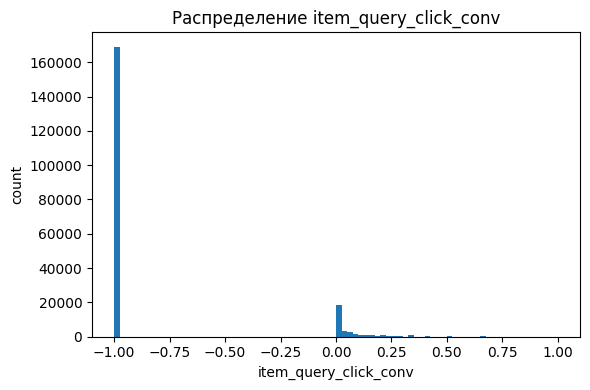

In [36]:
# Гистограмма item_query_click_conv
if "item_query_click_conv" in plot_df.columns:
    conv_vals = plot_df.select(pl.col("item_query_click_conv").cast(pl.Float64)).to_series().to_numpy()
    conv_vals = conv_vals[np.isfinite(conv_vals)]
    if len(conv_vals) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(conv_vals, bins=80)
        plt.title("Распределение item_query_click_conv")
        plt.xlabel("item_query_click_conv")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()


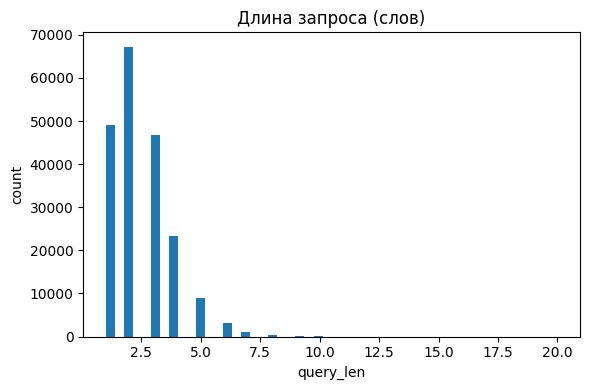

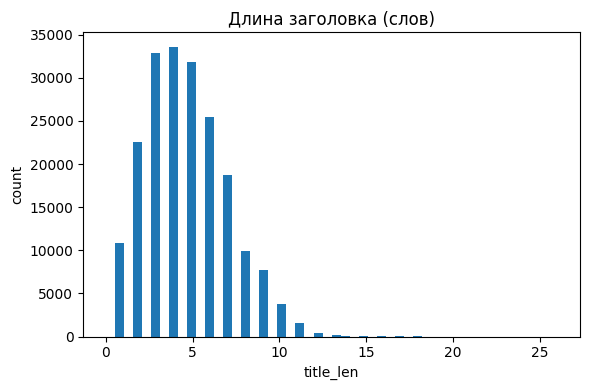

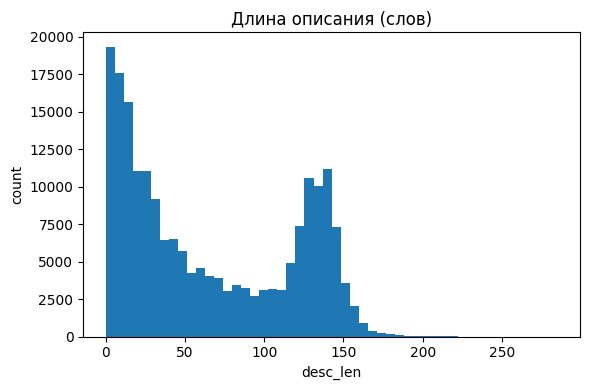

In [37]:
# Длины текстов
if has_text:
    q_len = plot_df.select(pl.col("query_len").cast(pl.Float64)).to_series().to_numpy()
    t_len = plot_df.select(pl.col("title_len").cast(pl.Float64)).to_series().to_numpy()
    d_len = plot_df.select(pl.col("desc_len").cast(pl.Float64)).to_series().to_numpy()

    plt.figure(figsize=(6, 4))
    plt.hist(q_len[np.isfinite(q_len)], bins=50)
    plt.title("Длина запроса (слов)")
    plt.xlabel("query_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(t_len[np.isfinite(t_len)], bins=50)
    plt.title("Длина заголовка (слов)")
    plt.xlabel("title_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(d_len[np.isfinite(d_len)], bins=50)
    plt.title("Длина описания (слов)")
    plt.xlabel("desc_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

In [38]:
test.head(5)

query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv
i64,i64,str,str,str,f32,f64,f32,i32,i32,i32,f32,f32
55,7540855789,"""1 сентября""","""Воздушные и гелиевые шары на 1…","""ВОЗДУШНЫЕ ШАРЫ К 1 СЕНТЯБРЯ 🍂 …",114.0,63.0,637640.0,114,2301564,637640,120.0,-1.0
55,7506720336,"""1 сентября""","""1 сентября фотозона""","""🎈Фотозона из шаров на 1 сентяб…",114.0,63.0,637640.0,114,2301564,637640,5000.0,-1.0
55,3110733862,"""1 сентября""","""Букет на 1 сентября из зефира""","""Букеты на 1 сентября Фото 1.…",114.0,63.0,637640.0,114,1090077,637640,1200.0,-1.0
55,7587733901,"""1 сентября""","""Спектакль-пантомима на 1 сентя…","""Спектакль-пантомима на 1 сентя…",114.0,63.0,637640.0,114,2301563,637640,0.0,-1.0
55,7552455685,"""1 сентября""","""Воздушные гелиевые шары с дост…","""Воздушные шары для оформления …",114.0,63.0,637640.0,114,2301564,637640,100.0,-1.0


In [43]:
ex = train.filter(pl.col("query_id") == 757116)
ex

query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact,query_tokens,title_tokens,desc_tokens,query_len,title_len,desc_len,overlap_q_title,overlap_q_desc
i64,i64,str,str,str,f32,f64,f32,i32,i32,i32,f32,f32,f32,list[str],list[str],list[str],u32,u32,u32,u32,u32
757116,7272304632,"""повар""","""Повар""","""""",112.0,62.0,0.0,112,62,638790,5000.0,0.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
757116,1911918753,"""повар""","""Повар""","""знание , европейской,итальянск…",112.0,62.0,0.0,112,62,637640,7000.0,0.027,0.0,"[""повар""]","[""повар""]","[""знание"", ""европейской"", … ""с""]",1,1,115,1,0
757116,4408324839,"""повар""","""Повар г/ц""","""Стаж более 25 лет из них 18в М…",112.0,62.0,0.0,112,62,637640,0.0,-1.0,0.0,"[""повар""]","[""повар"", ""г"", ""ц""]","[""стаж"", ""более"", … ""объёмах""]",1,3,20,1,0
757116,4600842279,"""повар""","""Повар""","""""",112.0,62.0,0.0,112,62,638790,80000.0,0.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
757116,3196572628,"""повар""","""Повар мне интересно""","""""",112.0,62.0,107620.0,112,62,637640,0.0,-1.0,0.0,"[""повар""]","[""повар"", ""мне"", ""интересно""]",[],1,3,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
757116,7253759823,"""повар""","""Повар с обучением""","""Поваром работала""",112.0,62.0,0.0,112,62,637770,0.0,0.053,0.0,"[""повар""]","[""повар"", ""с"", ""обучением""]","[""поваром"", ""работала""]",1,3,2,1,0
757116,7309049240,"""повар""","""Повар""","""""",112.0,62.0,0.0,112,62,637770,0.0,0.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
757116,7661062654,"""повар""","""Повар""","""""",112.0,62.0,107620.0,112,62,637640,0.0,-1.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
